# **Brain Haemorrhage Identification V2.0**

In [1]:
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import subprocess

# --- Phase 1: Lightweight packages ---
phase1 = [
    "scikit-learn",
    "torch",
    "matplotlib",
    "seaborn",
    "ultralytics",
    "pandas",
    "opencv-python"
]

# --- Function to install packages with live output ---
def install_packages(package_list, phase_name):
    logs = []
    display(HTML(f"<h3>🚀 Starting {phase_name}</h3>"))
    for pkg in tqdm(package_list, desc=f"{phase_name}", unit="pkg"):
        display(HTML(f"<b>Installing:</b> {pkg}"))
        process = subprocess.Popen(
            ["pip", "install", "--no-cache-dir", "--upgrade", pkg],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )
        output = ""
        for line in process.stdout:
            output += line
        process.wait()
        logs.append(f"📦 {pkg}\n{output}")
    return logs

# --- Run both phases ---
logs_phase1 = install_packages(phase1, "Phase 1: Core Packages")

# --- Display combined logs ---
all_logs = logs_phase1
scrollable_logs = (
    "<pre style='max-height: 400px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>"
    + "\n\n".join(all_logs) + "</pre>"
)
display(HTML(scrollable_logs))

Phase 1: Core Packages:   0%|          | 0/7 [00:00<?, ?pkg/s]

In [2]:
!pip install "numpy<2.0" pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatible.
catego

In [3]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split

BASE_DIR = "/kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0"
IMG_DIR  = os.path.join(BASE_DIR, "Patients_CT")

print("Base:", BASE_DIR)
print("Images:", IMG_DIR)
print("Patient folders:", os.listdir(IMG_DIR)[:10])

Base: /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0
Images: /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT
Patient folders: ['057', '086', '121', '061', '053', '051', '095', '078', '056', '120']


In [4]:
# Loading the csv data
hem_data = pd.read_csv(os.path.join(BASE_DIR, "hemorrhage_diagnosis.csv"))
hem_data.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [5]:
hem_data.columns

Index(['PatientNumber', 'SliceNumber', 'Intraventricular', 'Intraparenchymal',
       'Subarachnoid', 'Epidural', 'Subdural', 'No_Hemorrhage',
       'Fracture_Yes_No'],
      dtype='object')

In [6]:
# Create zero-padded patient folder names
hem_data["PatientFolder"] = hem_data["PatientNumber"].apply(lambda x: f"{int(x):03d}")
hem_data[["PatientNumber", "PatientFolder"]].head()

,PatientNumber,PatientFolder
0,49,049
1,49,049
2,49,049
3,49,049
4,49,049


In [7]:
# 3. Mapping function for BRAIN images (as earlier)
def get_brain_image_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    brain_dir = os.path.join(IMG_DIR, folder, "brain")

    candidates = [
        f"{slice_num}.jpg",
        f"{slice_num}.png",
        f"{slice_num}.jpeg",
        f"Slice_{slice_num}.jpg",
        f"Slice_{slice_num}.png"
    ]

    for name in candidates:
        full_path = os.path.join(brain_dir, name)
        if os.path.exists(full_path):
            return full_path
    return None

In [8]:
# Apply brain mapping
hem_data["image_path"] = hem_data.apply(get_brain_image_path, axis=1)
mapped_df = hem_data[hem_data["image_path"].notnull()].reset_index(drop=True)

mapped_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path
0,49,1,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
1,49,2,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
2,49,3,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
3,49,4,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
4,49,5,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...


## **Create the Binary Hemorrhage Label**

In [9]:
# Define the hemorrhage subtype columns
hemo_cols = [
    "Intraventricular", "Intraparenchymal",
    "Subarachnoid", "Epidural",
    "Subdural", "Fracture_Yes_No"
]

In [10]:
# Create binary label
mapped_df["Binary_Hemorrhage"] = (mapped_df[hemo_cols].sum(axis=1) > 0).astype(int)

In [11]:
# Check counts
mapped_df["Binary_Hemorrhage"].value_counts()

Binary_Hemorrhage
0    2109
1     392
Name: count, dtype: int64

In [12]:
# Create brain & bone image paths
def get_brain_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    dir_path = os.path.join(IMG_DIR, folder, "brain")

    candidates = [
        f"{slice_num}.jpg", f"{slice_num}.png",
        f"Slice_{slice_num}.jpg", f"Slice_{slice_num}.png"
    ]
    for name in candidates:
        if os.path.exists(os.path.join(dir_path, name)):
            return os.path.join(dir_path, name)
    return None


def get_bone_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    dir_path = os.path.join(IMG_DIR, folder, "bone")

    candidates = [
        f"{slice_num}.jpg", f"{slice_num}.png",
        f"Slice_{slice_num}.jpg", f"Slice_{slice_num}.png"
    ]
    for name in candidates:
        if os.path.exists(os.path.join(dir_path, name)):
            return os.path.join(dir_path, name)
    return None

In [13]:
# Apply mappings
mapped_df["brain_path"] = mapped_df.apply(get_brain_path, axis=1)
mapped_df["bone_path"]  = mapped_df.apply(get_bone_path, axis=1)

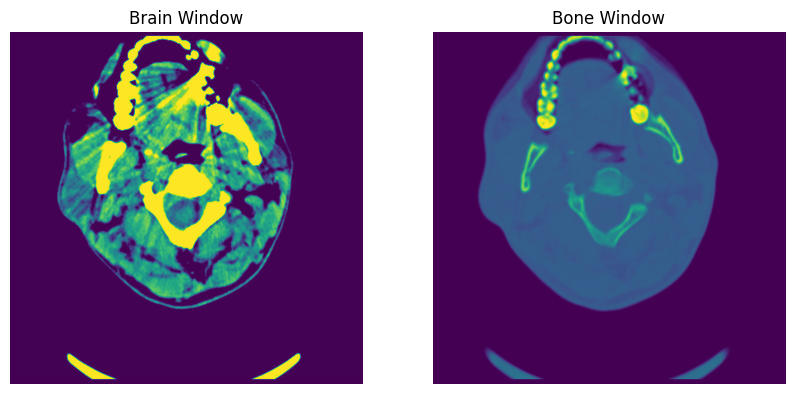

In [14]:
# Visual validation
import matplotlib.pyplot as plt
from PIL import Image

def show_brain_bone(idx):
    row = mapped_df.iloc[idx]
    brain = Image.open(row["brain_path"])
    bone  = Image.open(row["bone_path"])

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(brain)
    plt.title("Brain Window")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(bone)
    plt.title("Bone Window")
    plt.axis("off")
    plt.show()

show_brain_bone(0)

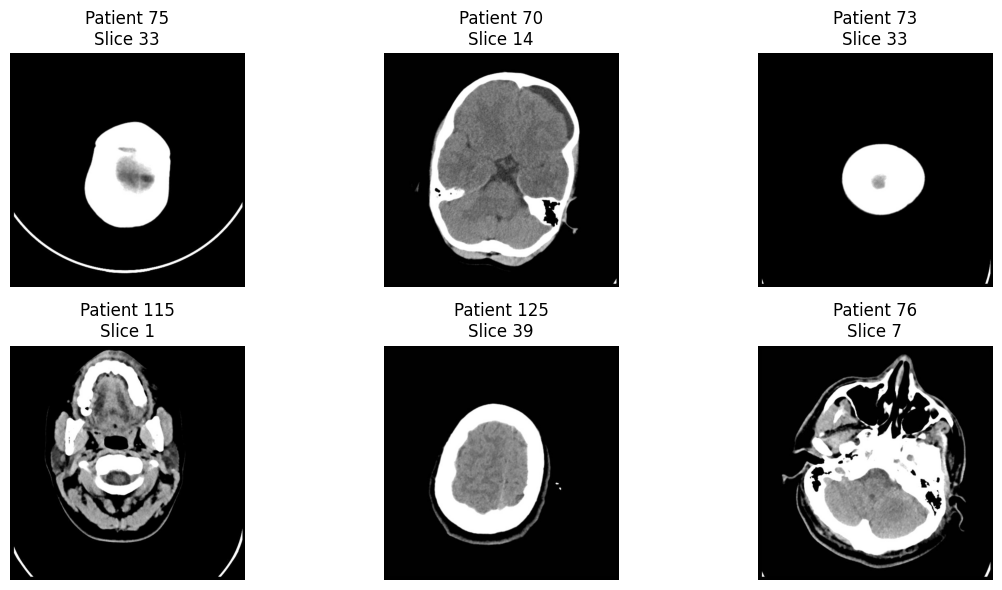

In [15]:
# SHOW RANDOM ORIGINAL BRAIN CT IMAGES
import matplotlib.pyplot as plt
import random

def show_random_images(df, n=6):
    plt.figure(figsize=(12, 6))

    for i in range(n):
        idx = random.randint(0, len(df)-1)
        row = df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")

        plt.subplot(2, n//2, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Patient {row['PatientNumber']}\nSlice {row['SliceNumber']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(mapped_df, n=6)

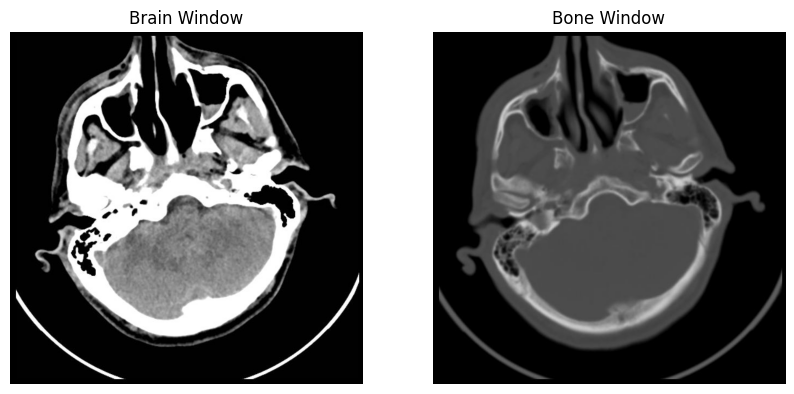

In [16]:
# Show brain vs bone window
def show_brain_bone(patient_folder, slice_num):
    brain_path = os.path.join(IMG_DIR, patient_folder, "brain", f"{slice_num}.jpg")
    bone_path  = os.path.join(IMG_DIR, patient_folder, "bone",  f"{slice_num}.jpg")

    brain_img = Image.open(brain_path).convert("RGB")
    bone_img  = Image.open(bone_path).convert("RGB")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(brain_img)
    plt.title("Brain Window")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(bone_img)
    plt.title("Bone Window")
    plt.axis("off")

    plt.show()

# Example:
show_brain_bone("049", 10)

## **Patient-wise Split + Oversampling for Brain+Bone Model**

In [17]:
# Removing null values
mapped_df = mapped_df.dropna(subset=["brain_path", "bone_path"]).reset_index(drop=True)

In [18]:
print("Missing brain:", mapped_df["brain_path"].isnull().sum())
print("Missing bone :", mapped_df["bone_path"].isnull().sum())

Missing brain: 0
Missing bone : 0


In [19]:
# Patient-wise Split
patients = mapped_df["PatientFolder"].unique()

from sklearn.model_selection import train_test_split

train_patients, temp_patients = train_test_split(
    patients, test_size=0.20, random_state=42
)

val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

train_df = mapped_df[mapped_df["PatientFolder"].isin(train_patients)].reset_index(drop=True)
val_df   = mapped_df[mapped_df["PatientFolder"].isin(val_patients)].reset_index(drop=True)
test_df  = mapped_df[mapped_df["PatientFolder"].isin(test_patients)].reset_index(drop=True)

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))

Train: 1986
Val  : 234
Test : 280


In [20]:
# Check binary class balance
print("Train class counts:")
print(train_df["Binary_Hemorrhage"].value_counts())

Train class counts:
Binary_Hemorrhage
0    1701
1     285
Name: count, dtype: int64


In [21]:
# Transforms
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [22]:
# Dataset class for Brain + Bone
class BrainBoneDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        brain = Image.open(row["brain_path"]).convert("RGB")
        bone  = Image.open(row["bone_path"]).convert("RGB")

        if self.transform:
            brain = self.transform(brain)
            bone  = self.transform(bone)

        label = torch.tensor(row["Binary_Hemorrhage"], dtype=torch.float32)
        return brain, bone, label

In [23]:
# Dataset created
train_dataset = BrainBoneDataset(train_df, transform=train_transform)
val_dataset   = BrainBoneDataset(val_df,   transform=val_transform)
test_dataset  = BrainBoneDataset(test_df,  transform=val_transform)

In [24]:
# Oversampling
class_counts = train_df["Binary_Hemorrhage"].value_counts()
print(class_counts)

sample_weights = train_df["Binary_Hemorrhage"].apply(
    lambda x: 1.0 / class_counts[x]
).values

Binary_Hemorrhage
0    1701
1     285
Name: count, dtype: int64


In [25]:
# Create sampler
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

In [26]:
# DataLoaders with Oversampling
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [27]:
# Validate oversampling works
for i in range(3):
    brain, bone, labels = next(iter(train_loader))
    print(f"Batch {i+1} hemorrhage count:", labels.sum().item(), "/", len(labels))

Batch 1 hemorrhage count: 6.0 / 16
Batch 2 hemorrhage count: 7.0 / 16
Batch 3 hemorrhage count: 12.0 / 16


## **Build the Dual-Branch EfficientNet (Brain + Bone Fusion Model)**

              Brain Image ────────────┐
                                      │
          EfficientNet-B0 (brain) ────┤── concatenate ── FC ── output (1)
                                      │
              Bone Image ─────────────┘
          EfficientNet-B0 (bone)

In [28]:
# Model Definition
class DualBranchEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Brain branch
        self.brain_net = models.efficientnet_b0(weights="DEFAULT")
        in_features = self.brain_net.classifier[1].in_features
        self.brain_net.classifier[1] = nn.Identity()   # remove final FC

        # Bone branch
        self.bone_net = models.efficientnet_b0(weights="DEFAULT")
        self.bone_net.classifier[1] = nn.Identity()

        # Fusion head
        self.fc = nn.Linear(in_features * 2, 1)  # binary output

    def forward(self, brain_img, bone_img):
        brain_feat = self.brain_net(brain_img)  # [B, 1280]
        bone_feat  = self.bone_net(bone_img)    # [B, 1280]

        fused = torch.cat((brain_feat, bone_feat), dim=1)  # [B, 2560]

        output = self.fc(fused)  # [B, 1]
        return output

In [29]:
# Initialize Model, Loss, Optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return loss.mean()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualBranchEfficientNet().to(device)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]


In [31]:
# Test the model with one batch
brain, bone, labels = next(iter(train_loader))
brain, bone, labels = brain.to(device), bone.to(device), labels.to(device)

with torch.no_grad():
    out = model(brain, bone)
    print("Output shape:", out.shape)

Output shape: torch.Size([16, 1])


## **Train the Dual-Branch Model (full training loop)**

In [32]:
# Training Function
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for brain, bone, labels in loader:
        brain = brain.to(device)
        bone = bone.to(device)
        labels = labels.to(device).unsqueeze(1)  # [B] -> [B,1]

        optimizer.zero_grad()

        outputs = model(brain, bone)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [33]:
# Validation Function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for brain, bone, labels in loader:
            brain = brain.to(device)
            bone = bone.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(brain, bone)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [34]:
# Training Loop With Model Saving
EPOCHS = 10   # you can increase to 15–20 later
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss  : {val_loss:.4f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_dual_model.pth")
        print("  -> Saved best model")

Epoch 1/10
  Train Loss: 0.0236
  Val Loss  : 0.0156
  -> Saved best model
Epoch 2/10
  Train Loss: 0.0154
  Val Loss  : 0.0168
Epoch 3/10
  Train Loss: 0.0099
  Val Loss  : 0.0156
Epoch 4/10
  Train Loss: 0.0092
  Val Loss  : 0.0159
Epoch 5/10
  Train Loss: 0.0079
  Val Loss  : 0.0110
  -> Saved best model
Epoch 6/10
  Train Loss: 0.0073
  Val Loss  : 0.0140
Epoch 7/10
  Train Loss: 0.0064
  Val Loss  : 0.0112
Epoch 8/10
  Train Loss: 0.0059
  Val Loss  : 0.0189
Epoch 9/10
  Train Loss: 0.0045
  Val Loss  : 0.0177
Epoch 10/10
  Train Loss: 0.0031
  Val Loss  : 0.0277


In [35]:
# Verify the model saved
os.path.exists("best_dual_model.pth")

True

## **Evaluation of the Dual-Branch Hemorrhage Detector**

In [36]:
# Load the Best Saved Model
best_model = DualBranchEfficientNet().to(device)
best_model.load_state_dict(torch.load("best_dual_model.pth"))
best_model.eval()

DualBranchEfficientNet(
  (brain_net): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

In [37]:
mapped_df[mapped_df["bone_path"].isnull()].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path,Binary_Hemorrhage,brain_path,bone_path


In [38]:
mapped_df[mapped_df["brain_path"].isnull()].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path,Binary_Hemorrhage,brain_path,bone_path


In [39]:
# Make Predictions on Test Set
import torch.nn.functional as F

all_logits = []
all_probs  = []
all_labels = []

with torch.no_grad():
    for brain, bone, labels in test_loader:
        brain = brain.to(device)
        bone = bone.to(device)
        
        logits = best_model(brain, bone)
        probs = torch.sigmoid(logits)

        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(labels)

# Combine into single tensors
all_logits = torch.cat(all_logits).numpy().flatten()
all_probs  = torch.cat(all_probs).numpy().flatten()
all_labels = torch.cat(all_labels).numpy().flatten()

In [40]:
# Compute Basic Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Default threshold for now
preds_05 = (all_probs > 0.5).astype(int)

acc = accuracy_score(all_labels, preds_05)
prec = precision_score(all_labels, preds_05, zero_division=0)
rec = recall_score(all_labels, preds_05, zero_division=0)
f1  = f1_score(all_labels, preds_05, zero_division=0)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

Accuracy : 0.7642857142857142
Precision: 0.6582278481012658
Recall   : 0.5714285714285714
F1 Score : 0.611764705882353


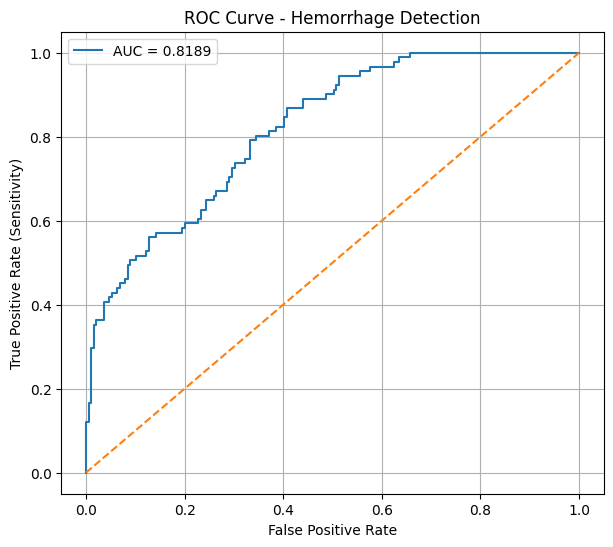

In [41]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Hemorrhage Detection")
plt.legend()
plt.grid()
plt.show()

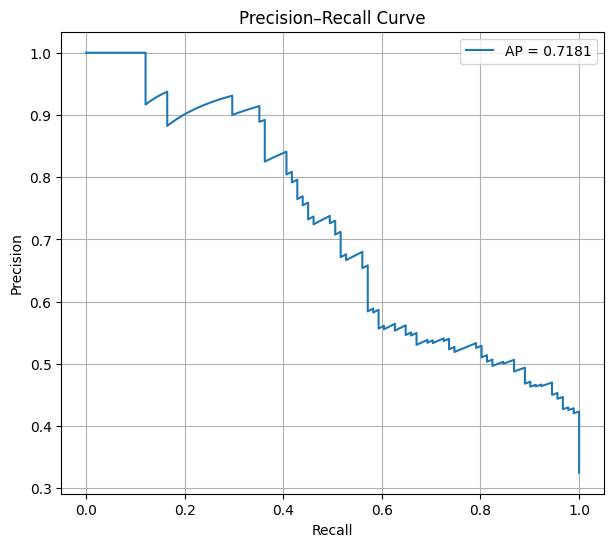

In [42]:
# Precision–Recall Curve and AUC
from sklearn.metrics import precision_recall_curve, average_precision_score

precisions, recalls, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid()
plt.show()

## **Find Optimal Thresholds**

In [43]:
import numpy as np

# F1 threshold
f1_scores = []
for t in thresholds:
    preds = (all_probs > t).astype(int)
    f1_scores.append(f1_score(all_labels, preds, zero_division=0))
best_f1_thresh = thresholds[np.argmax(f1_scores)]

# Youden's J threshold (maximizes sensitivity+specificity)
J = tpr - fpr
best_j_thresh = thresholds[np.argmax(J)]

# ROC min-distance threshold
dist = np.sqrt((1-tpr)**2 + (fpr)**2)
best_roc_thresh = thresholds[np.argmin(dist)]

# PR-F1 threshold using PR curve
f1_pr_scores = (2*precisions*recalls)/(precisions+recalls+1e-8)
best_pr_thresh = pr_thresholds[np.argmax(f1_pr_scores[:-1])]  # last element is nan

In [44]:
print("=== Optimal Thresholds ===")
print(f"Best F1 Threshold          : {best_f1_thresh:.3f}")
print(f"Best Youden J Threshold    : {best_j_thresh:.3f}")
print(f"Best ROC Distance Threshold: {best_roc_thresh:.3f}")
print(f"Best PR-F1 Threshold       : {best_pr_thresh:.3f}")

=== Optimal Thresholds ===
Best F1 Threshold          : 0.294
Best Youden J Threshold    : 0.257
Best ROC Distance Threshold: 0.295
Best PR-F1 Threshold       : 0.257


In [45]:
# Evaluating with that threshold
opt_thresh = best_pr_thresh  # or best_f1_thresh

preds_opt = (all_probs > opt_thresh).astype(int)

acc = accuracy_score(all_labels, preds_opt)
prec = precision_score(all_labels, preds_opt)
rec = recall_score(all_labels, preds_opt)
f1  = f1_score(all_labels, preds_opt)

print("Optimized Accuracy :", acc)
print("Optimized Precision:", prec)
print("Optimized Recall   :", rec)
print("Optimized F1       :", f1)

Optimized Accuracy : 0.6785714285714286
Optimized Precision: 0.5032258064516129
Optimized Recall   : 0.8571428571428571
Optimized F1       : 0.6341463414634146


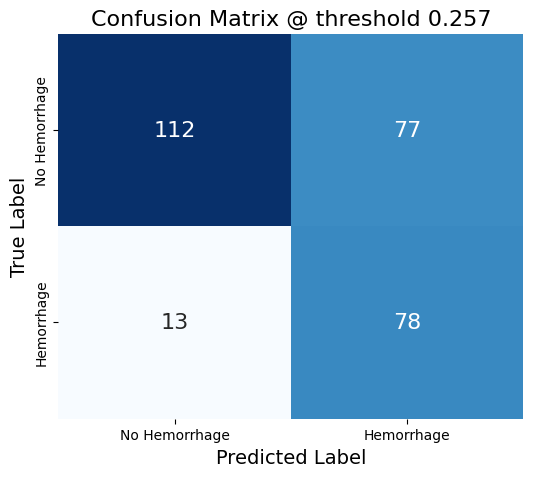

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, preds_opt)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 16}
)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title(f"Confusion Matrix @ threshold {opt_thresh:.3f}", fontsize=16)
plt.xticks([0.5,1.5], ["No Hemorrhage", "Hemorrhage"])
plt.yticks([0.5,1.5], ["No Hemorrhage", "Hemorrhage"])
plt.show()

## **Load a Single Validation Image & Run Inference**

Image paths:
Brain: /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/059/brain/12.jpg
Bone : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/059/bone/12.jpg
True Label: 0


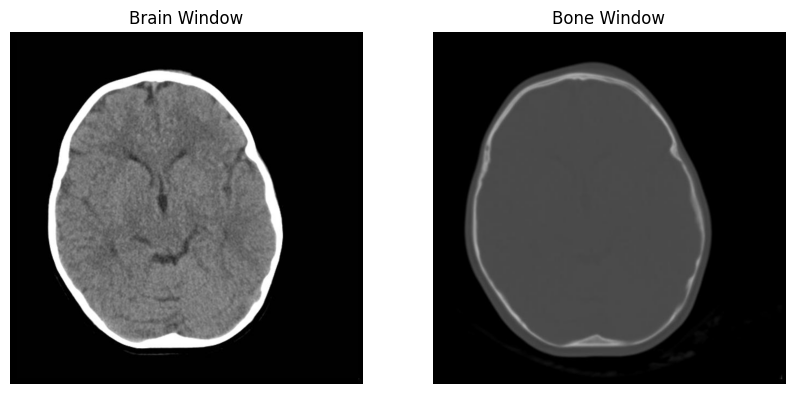


Predicted probability of Hemorrhage: 0.1409
Predicted Label: 0 (Threshold = 0.257)
True Label     : 0


In [47]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

# Load best saved model
model = DualBranchEfficientNet().to(device)
model.load_state_dict(torch.load("best_dual_model.pth", map_location=device))
model.eval()

# Pick a random index from validation set
idx = random.randint(0, len(val_df)-1)
row = val_df.iloc[idx]

brain_path = row["brain_path"]
bone_path  = row["bone_path"]
true_label = row["Binary_Hemorrhage"]

print("Image paths:")
print("Brain:", brain_path)
print("Bone :", bone_path)
print("True Label:", true_label)

# Load images
brain_img = Image.open(brain_path).convert("RGB")
bone_img  = Image.open(bone_path).convert("RGB")

# Show images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(brain_img)
plt.title("Brain Window")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bone_img)
plt.title("Bone Window")
plt.axis("off")

plt.show()

# Transform (same as val_transform)
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

brain_tensor = val_tf(brain_img).unsqueeze(0).to(device)
bone_tensor  = val_tf(bone_img).unsqueeze(0).to(device)

# Run model
with torch.no_grad():
    output = model(brain_tensor, bone_tensor)
    prob = torch.sigmoid(output).item()

print(f"\nPredicted probability of Hemorrhage: {prob:.4f}")

# Use your optimized threshold
opt_thresh = best_pr_thresh  # make sure this variable exists in your notebook

pred_label = 1 if prob > opt_thresh else 0
print(f"Predicted Label: {pred_label} (Threshold = {opt_thresh:.3f})")
print(f"True Label     : {true_label}")

## **Grad-CAM helper class (for the brain branch)**

In [48]:
class BrainGradCAM:
    def __init__(self, model, target_layer):
        """
        model: DualBranchEfficientNet
        target_layer: layer from model.brain_net to hook (e.g. model.brain_net.features[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Forward hook: store feature maps
        self.fwd_hook = target_layer.register_forward_hook(self._save_activations)
        # Backward hook: store gradients
        self.bwd_hook = target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output.detach()

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, brain_tensor, bone_tensor, class_idx=None):
        """
        brain_tensor, bone_tensor: [1, 3, H, W] on device
        class_idx: which logit to use (for binary model, this is 0)
        """
        self.model.eval()
        self.model.zero_grad()

        # Forward
        output = self.model(brain_tensor, bone_tensor)  # [1,1]
        if class_idx is None:
            score = output[0, 0]
        else:
            score = output[0, class_idx]

        # Backward
        score.backward()

        # Grad-CAM calculation
        # activations: [B, C, H, W]
        # gradients:   [B, C, H, W]
        grads = self.gradients       # [1, C, H, W]
        acts  = self.activations     # [1, C, H, W]

        # Global average pool the gradients: [C]
        weights = grads.mean(dim=(2, 3))[0]          # [C]
        cam = (weights[:, None, None] * acts[0]).sum(dim=0)  # [H, W]

        # ReLU
        cam = torch.relu(cam)

        # Normalize to [0, 1]
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        cam_np = cam.cpu().numpy()
        return cam_np

In [49]:
brain_target_layer = model.brain_net.features[-1]
gradcam = BrainGradCAM(model, brain_target_layer)

In [50]:
# Pick a validation slice and run Grad-CAM
import random
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms

# If you named your val transform differently, adjust this:
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 1) Pick a random validation sample
idx = random.randint(0, len(val_df)-1)
row = val_df.iloc[idx]

brain_path = row["brain_path"]
bone_path  = row["bone_path"]
true_label = row["Binary_Hemorrhage"]

print("Sample index:", idx)
print("Brain path :", brain_path)
print("Bone path  :", bone_path)
print("True label :", true_label)

# 2) Load images (original size for visualization)
brain_img_orig = Image.open(brain_path).convert("RGB")
bone_img_orig  = Image.open(bone_path).convert("RGB")

# 3) Preprocess for the model
brain_tensor = val_tf(brain_img_orig).unsqueeze(0).to(device)
bone_tensor  = val_tf(bone_img_orig).unsqueeze(0).to(device)

# 4) Forward pass and predicted probability
model.eval()
with torch.no_grad():
    logits = model(brain_tensor, bone_tensor)
    prob = torch.sigmoid(logits).item()

# Use your optimal threshold (make sure best_pr_thresh exists)
opt_thresh = best_pr_thresh
pred_label = 1 if prob > opt_thresh else 0

print(f"\nPredicted probability of hemorrhage: {prob:.4f}")
print(f"Predicted label (threshold {opt_thresh:.3f}): {pred_label}")
print(f"True label: {true_label}")

Sample index: 229
Brain path : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/124/brain/26.jpg
Bone path  : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/124/bone/26.jpg
True label : 0

Predicted probability of hemorrhage: 0.0802
Predicted label (threshold 0.257): 0
True label: 0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


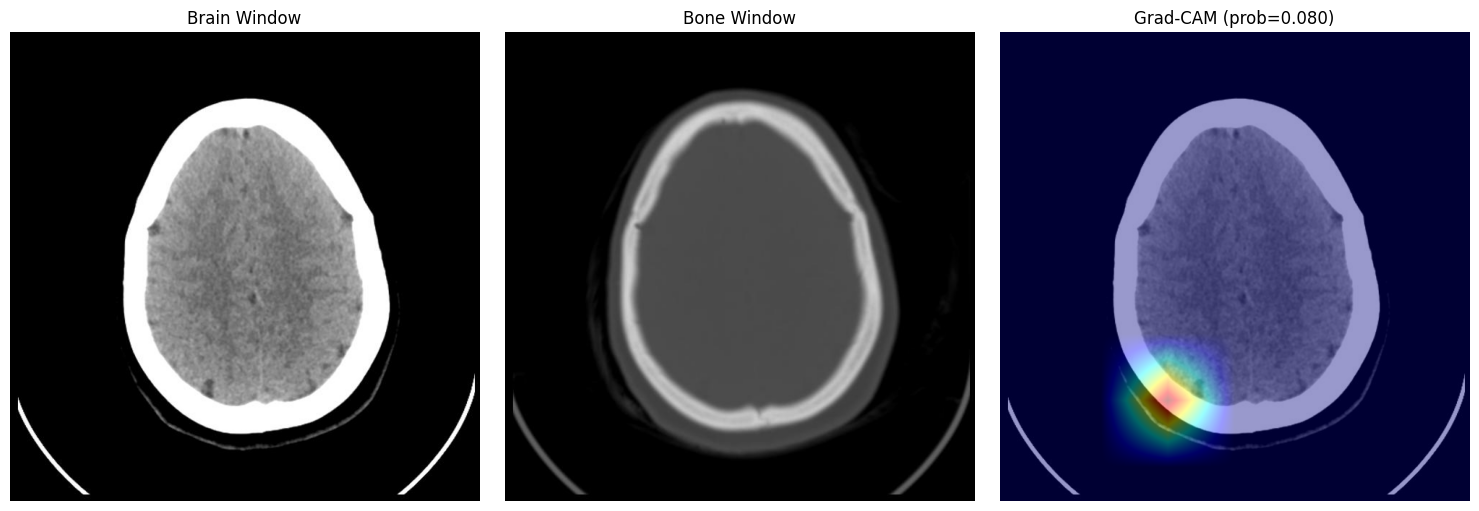

In [51]:
# Generate Grad-CAM heatmap for the brain branch
import cv2

brain_tensor.requires_grad = True
bone_tensor.requires_grad  = True

cam = gradcam.generate_cam(brain_tensor, bone_tensor)  # [Hc, Wc] in [0,1]

# 6) Resize CAM to original image size
cam_resized = cv2.resize(cam, brain_img_orig.size)  # (W, H)

# 7) Convert CAM to color heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# 8) Overlay heatmap on the brain image
brain_np = np.array(brain_img_orig)
overlay = np.uint8(0.4 * heatmap + 0.6 * brain_np)

# 9) Plot everything
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(brain_img_orig)
plt.title("Brain Window")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(bone_img_orig)
plt.title("Bone Window")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title(f"Grad-CAM (prob={prob:.3f})")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Add bounding box extraction from Grad-CAM**

In [52]:
# Convert Grad-CAM to a bounding box
# Threshold CAM (tune threshold if needed)
thresh = cam_resized > 0.5     # 0.5 is common, adjust if needed
mask = np.uint8(thresh)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    boxes.append((x, y, w, h))

In [53]:
# Draw bounding box on original CT slice
brain_with_box = brain_np.copy()

for (x, y, w, h) in boxes:
    cv2.rectangle(brain_with_box, (x, y), (x+w, y+h), (255, 0, 0), 2)  # blue box

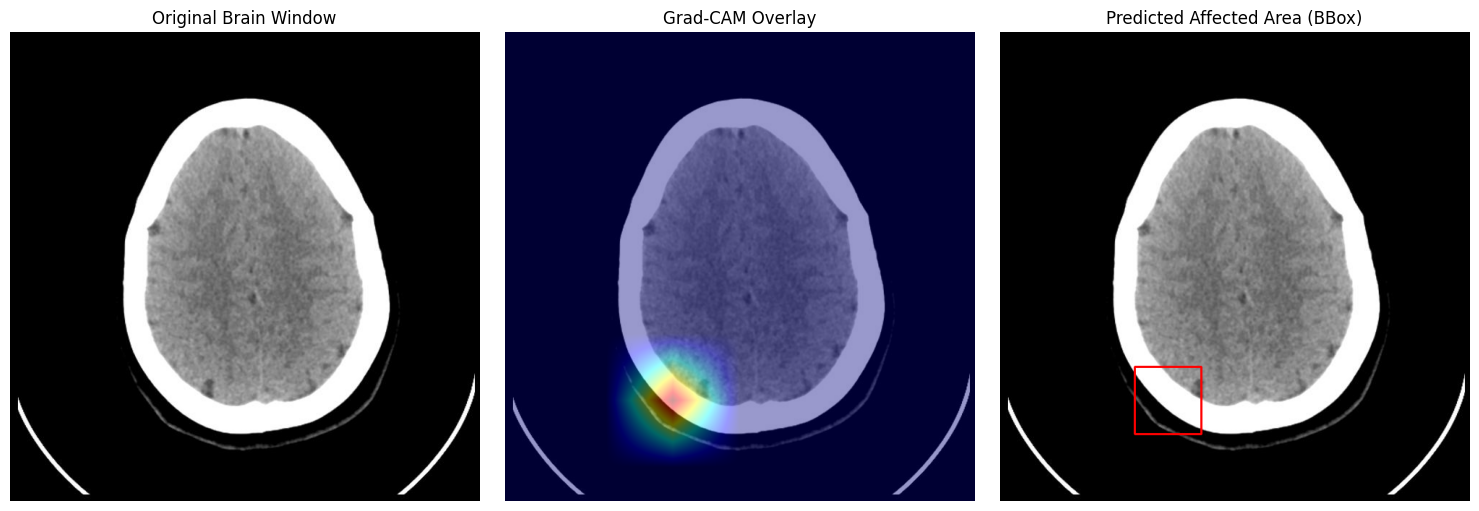

In [54]:
# Visualize heatmap + bounding box side-by-side
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(brain_img_orig)
plt.title("Original Brain Window")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(brain_with_box)
plt.title("Predicted Affected Area (BBox)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

def visualize_prediction(idx, threshold=0.5):
    row = val_df.iloc[idx]

    brain_path = row["brain_path"]
    bone_path  = row["bone_path"]
    true_label = row["Binary_Hemorrhage"]

    brain_img_orig = Image.open(brain_path).convert("RGB")
    bone_img_orig  = Image.open(bone_path).convert("RGB")

    # Preprocess
    val_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                            [0.229,0.224,0.225])
    ])

    brain_tensor = val_tf(brain_img_orig).unsqueeze(0).to(device)
    bone_tensor  = val_tf(bone_img_orig).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        logits = model(brain_tensor, bone_tensor)
        prob = torch.sigmoid(logits).item()

    pred_label = 1 if prob > threshold else 0

    # --------------------------
    # CASE 1 → NO HEMORRHAGE
    # --------------------------
    if pred_label == 0:
        plt.figure(figsize=(6,5))
        plt.imshow(brain_img_orig)
        plt.title(f"Prediction: NO HEMORRHAGE (prob={prob:.3f})\nTrue Label: {true_label}")
        plt.axis("off")
        plt.show()
        return

    # --------------------------
    # CASE 2 → HEMORRHAGE DETECTED
    # --------------------------
    # Grad-CAM
    brain_tensor.requires_grad = True
    bone_tensor.requires_grad  = True

    cam = gradcam.generate_cam(brain_tensor, bone_tensor)  # [Hc, Wc]

    cam_resized = cv2.resize(cam, brain_img_orig.size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    brain_np = np.array(brain_img_orig)
    overlay = np.uint8(0.6 * brain_np + 0.4 * heatmap)

    # Bounding box extraction
    mask = cam_resized > 0.5
    mask_uint8 = np.uint8(mask * 255)

    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brain_with_box = brain_np.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(brain_with_box, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Plot results
    plt.figure(figsize=(16,6))

    plt.subplot(1,3,1)
    plt.imshow(brain_img_orig)
    plt.title("Original Brain Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Overlay")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(brain_with_box)
    plt.title("Detected Region (Bounding Box)")
    plt.axis("off")

    plt.suptitle(
        f"Prediction: HEMORRHAGE (prob={prob:.3f}) | True Label: {true_label}", 
        fontsize=14, y=1.02
    )

    plt.tight_layout()
    plt.show()

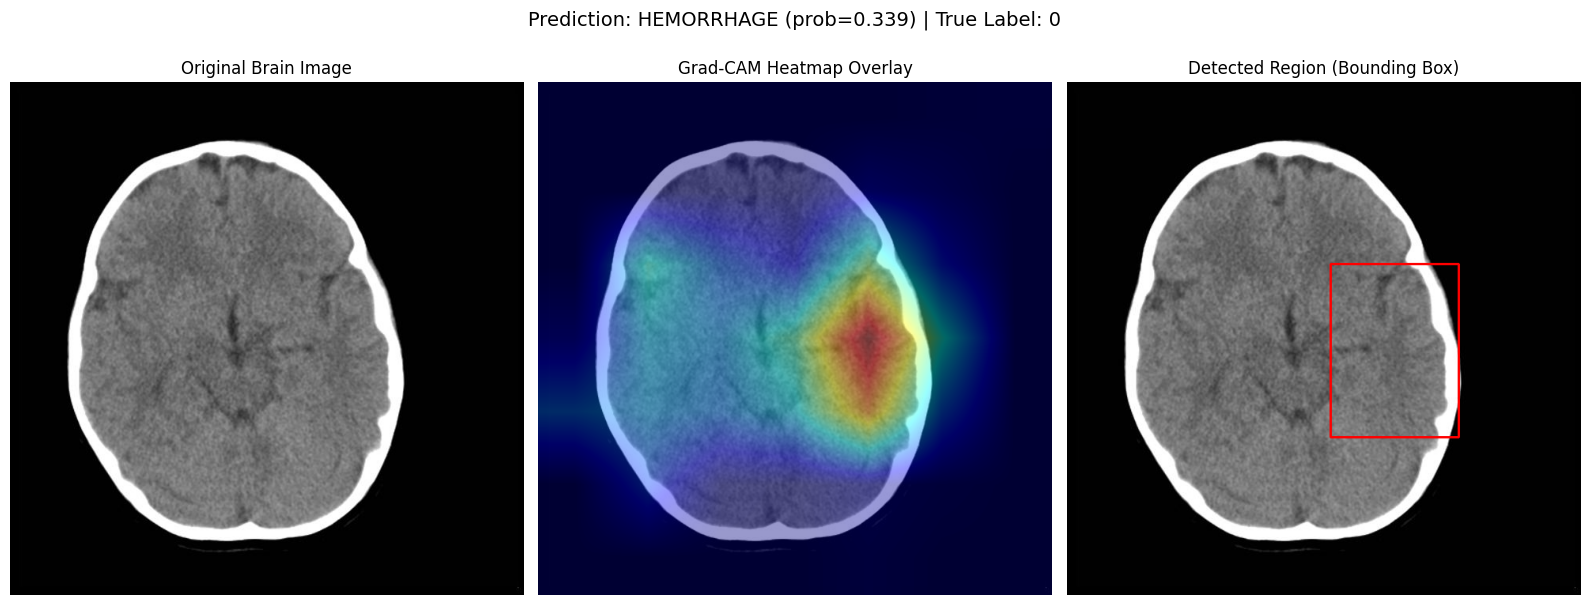

In [56]:
visualize_prediction(idx=10, threshold=best_pr_thresh)

# **STAGE 2 — Multi-Label Hemorrhage Subtype Classifier**

In [57]:
from sklearn.model_selection import train_test_split

# Columns for subtype labels
subtype_cols = [
    "Intraventricular",
    "Intraparenchymal",
    "Subarachnoid",
    "Epidural",
    "Subdural",
    "Fracture_Yes_No"
]

# Keep only slices where hemorrhage is present (Binary_Hemorrhage == 1)
sub_df = mapped_df[mapped_df["Binary_Hemorrhage"] == 1].reset_index(drop=True)

# Safety: ensure brain & bone paths are valid
sub_df = sub_df.dropna(subset=["brain_path", "bone_path"]).reset_index(drop=True)

print("Total hemorrhage slices for Stage 2:", len(sub_df))
sub_df.head()

Total hemorrhage slices for Stage 2: 392


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path,Binary_Hemorrhage,brain_path,bone_path
0,49,14,0,0,0,1,0,0,1,049,/kaggle/input/computed-tomography-ct-images/co...,1,/kaggle/input/computed-tomography-ct-images/co...,/kaggle/input/computed-tomography-ct-images/co...
1,49,15,0,0,0,1,0,0,1,049,/kaggle/input/computed-tomography-ct-images/co...,1,/kaggle/input/computed-tomography-ct-images/co...,/kaggle/input/computed-tomography-ct-images/co...
2,49,16,0,0,0,1,0,0,0,049,/kaggle/input/computed-tomography-ct-images/co...,1,/kaggle/input/computed-tomography-ct-images/co...,/kaggle/input/computed-tomography-ct-images/co...
3,49,17,0,0,0,1,0,0,0,049,/kaggle/input/computed-tomography-ct-images/co...,1,/kaggle/input/computed-tomography-ct-images/co...,/kaggle/input/computed-tomography-ct-images/co...
4,49,20,0,0,0,1,0,0,1,049,/kaggle/input/computed-tomography-ct-images/co...,1,/kaggle/input/computed-tomography-ct-images/co...,/kaggle/input/computed-tomography-ct-images/co...


In [58]:
print("Subtype value counts (ALL hemorrhage slices):\n")
for col in subtype_cols:
    print(f"{col:20s}: {sub_df[col].sum()}")

Subtype value counts (ALL hemorrhage slices):

Intraventricular    : 24
Intraparenchymal    : 73
Subarachnoid        : 18
Epidural            : 173
Subdural            : 56
Fracture_Yes_No     : 195


## **Train/Val/Test Split (by patient)**

In [59]:
!pip install iterative-stratification

In [60]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import train_test_split
import numpy as np

# Build Patient-Level Label Table
patient_labels = sub_df.groupby("PatientFolder")[subtype_cols].max()

print("\nPatients per subtype:")
for col in subtype_cols:
    print(f"{col:20s} : {int(patient_labels[col].sum())}")


Patients per subtype:
Intraventricular     : 5
Intraparenchymal     : 16
Subarachnoid         : 7
Epidural             : 21
Subdural             : 4
Fracture_Yes_No      : 22


In [61]:
# Identify Rare-Type Patients
# (patients containing each subtype)
rare_patients = {
    col: list(patient_labels[patient_labels[col] == 1].index)
    for col in subtype_cols
}

print("\nRare patients per subtype:")
for col, pts in rare_patients.items():
    print(f"{col:20s}: {pts}")


Rare patients per subtype:
Intraventricular    : ['080', '085', '091', '092', '094']
Intraparenchymal    : ['049', '050', '051', '053', '058', '069', '071', '072', '076', '079', '080', '084', '091', '092', '094', '097']
Subarachnoid        : ['076', '080', '082', '084', '092', '093', '094']
Epidural            : ['049', '052', '053', '066', '067', '068', '070', '073', '074', '075', '077', '078', '083', '086', '087', '088', '089', '090', '092', '093', '097']
Subdural            : ['051', '071', '074', '081']
Fracture_Yes_No     : ['049', '050', '051', '052', '053', '067', '068', '069', '074', '076', '077', '078', '081', '082', '083', '087', '088', '092', '093', '094', '095', '097']


In [62]:
#  FORCEING AT LEAST 1 PATIENT FOR EACH SUBTYPE INTO VAL & TEST
val_patients = set()
test_patients = set()

for col, pts in rare_patients.items():
    if len(pts) == 1:
        # If only ONE patient has this type → put in VALIDATION
        val_patients.add(pts[0])
    elif len(pts) == 2:
        # If two → one goes to val, one to test
        val_patients.add(pts[0])
        test_patients.add(pts[1])
    else:
        # If many → first in val, second in test
        val_patients.add(pts[0])
        test_patients.add(pts[1])


print("\nForced VAL patients:", val_patients)
print("Forced TEST patients:", test_patients)


Forced VAL patients: {'051', '049', '076', '080'}
Forced TEST patients: {'085', '080', '052', '071', '050'}


In [63]:
# Remaining patients for normal stratified splitting
all_patients = set(patient_labels.index)

forced = val_patients.union(test_patients)
remaining_patients = list(all_patients - forced)

# Prepare data for stratified split
X = patient_labels.loc[remaining_patients][["Intraventricular"]]  # dummy
y = patient_labels.loc[remaining_patients][subtype_cols].values

# 80% of remaining → TRAIN
# 20% of remaining → TEMP (to split into VAL/TEST)
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(mskf.split(X, y))

train_rem_idx, temp_rem_idx = splits[0]

train_rem_patients = [remaining_patients[i] for i in train_rem_idx]
temp_rem_patients  = [remaining_patients[i] for i in temp_rem_idx]

print("\nRemaining patients for TRAIN:", len(train_rem_patients))
print("Remaining patients for TEMP:", len(temp_rem_patients))


Remaining patients for TRAIN: 23
Remaining patients for TEMP: 6


In [64]:
# TEMP → VAL + TEST (stratified again)
# BUT avoid assigning forced patients twice
temp_labels = patient_labels.loc[temp_rem_patients][subtype_cols].values
X_temp = patient_labels.loc[temp_rem_patients][["Intraventricular"]]

mskf2 = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
temp_splits = list(mskf2.split(X_temp, temp_labels))

val_temp_idx, test_temp_idx = temp_splits[0]

# Now combine forced + stratified split
train_patients = set(train_rem_patients)
val_patients   = set(val_patients).union([temp_rem_patients[i] for i in val_temp_idx])
test_patients  = set(test_patients).union([temp_rem_patients[i] for i in test_temp_idx])


print("\nFINAL PATIENT SPLIT COUNTS:")
print("TRAIN patients:", len(train_patients))
print("VAL patients  :", len(val_patients))
print("TEST patients :", len(test_patients))


FINAL PATIENT SPLIT COUNTS:
TRAIN patients: 23
VAL patients  : 7
TEST patients : 8


In [65]:
# STEP 6 — Build Slice-Level DataFrames for Stage 2
train_df2 = sub_df[sub_df["PatientFolder"].isin(train_patients)].reset_index(drop=True)
val_df2   = sub_df[sub_df["PatientFolder"].isin(val_patients)].reset_index(drop=True)
test_df2  = sub_df[sub_df["PatientFolder"].isin(test_patients)].reset_index(drop=True)

print("\nSlice counts:")
print("TRAIN slices:", len(train_df2))
print("VAL slices  :", len(val_df2))
print("TEST slices :", len(test_df2))


Slice counts:
TRAIN slices: 225
VAL slices  : 83
TEST slices : 95


In [66]:
# STEP 7 — Verify each subtype exists in each split
def show_split_class_counts(df, name):
    print(f"\n=== {name} CLASS COUNTS ===")
    for col in subtype_cols:
        print(f"{col:20s} : {df[col].sum()}")

show_split_class_counts(train_df2, "TRAIN")
show_split_class_counts(val_df2,   "VAL")
show_split_class_counts(test_df2,  "TEST")


=== TRAIN CLASS COUNTS ===
Intraventricular     : 6
Intraparenchymal     : 26
Subarachnoid         : 7
Epidural             : 118
Subdural             : 23
Fracture_Yes_No      : 110

=== VAL CLASS COUNTS ===
Intraventricular     : 10
Intraparenchymal     : 21
Subarachnoid         : 9
Epidural             : 26
Subdural             : 15
Fracture_Yes_No      : 44

=== TEST CLASS COUNTS ===
Intraventricular     : 18
Intraparenchymal     : 29
Subarachnoid         : 5
Epidural             : 29
Subdural             : 18
Fracture_Yes_No      : 41


## **Create Stage-2 Dataset Class**

In [82]:
# Dataset class (copy & paste)
from torch.utils.data import Dataset
from PIL import Image
import torch

class SubtypeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        brain = Image.open(row["brain_path"]).convert("RGB")
        bone  = Image.open(row["bone_path"]).convert("RGB")
        
        if self.transform:
            brain = self.transform(brain)
            bone  = self.transform(bone)
        
        labels = torch.tensor(
            np.array(row[subtype_cols], dtype=np.float32),
            dtype=torch.float32
        )

        
        return brain, bone, labels

In [83]:
# Transforms (train/val/test)
import torchvision.transforms as T

IMG_SIZE = 224

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],
                [0.229,0.224,0.225])
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],
                [0.229,0.224,0.225])
])

In [84]:
# Create DataLoaders
train_dataset2 = SubtypeDataset(train_df2, transform=train_tf)
val_dataset2   = SubtypeDataset(val_df2, transform=val_tf)
test_dataset2  = SubtypeDataset(test_df2, transform=val_tf)

train_loader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)
val_loader2   = DataLoader(val_dataset2, batch_size=16, shuffle=False)
test_loader2  = DataLoader(test_dataset2, batch_size=16, shuffle=False)

## **Add WeightedRandomSampler (to fix extreme class imbalance)**

In [85]:
# Compute class counts from the TRAIN set ONLY
class_counts = train_df2[subtype_cols].sum().to_dict()

print("Class frequencies:\n", class_counts)

# Convert to weights (inverse frequency)
class_weights = {c: 1.0 / class_counts[c] for c in subtype_cols}
class_weights

Class frequencies:
 {'Intraventricular': 6, 'Intraparenchymal': 26, 'Subarachnoid': 7, 'Epidural': 118, 'Subdural': 23, 'Fracture_Yes_No': 110}


{'Intraventricular': 0.16666666666666666,
 'Intraparenchymal': 0.038461538461538464,
 'Subarachnoid': 0.14285714285714285,
 'Epidural': 0.00847457627118644,
 'Subdural': 0.043478260869565216,
 'Fracture_Yes_No': 0.00909090909090909}

In [86]:
# Compute a weight for each sample in train_df2
sample_weights = []

for _, row in train_df2.iterrows():
    w = 1.0
    for col in subtype_cols:
        if row[col] == 1:
            w += class_weights[col]
    sample_weights.append(w)

sample_weights = np.array(sample_weights)

In [87]:
# Build WeightedRandomSampler
import torch
from torch.utils.data import WeightedRandomSampler

sampler2 = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),   # 1 epoch draws = dataset size
    replacement=True
)

In [88]:
# Convert subtype columns to numeric 0/1
for col in subtype_cols:
    train_df2[col] = pd.to_numeric(train_df2[col], errors="coerce").fillna(0).astype("int32")
    val_df2[col]   = pd.to_numeric(val_df2[col], errors="coerce").fillna(0).astype("int32")
    test_df2[col]  = pd.to_numeric(test_df2[col], errors="coerce").fillna(0).astype("int32")

In [89]:
train_df2[subtype_cols].dtypes

Intraventricular    int32
Intraparenchymal    int32
Subarachnoid        int32
Epidural            int32
Subdural            int32
Fracture_Yes_No     int32
dtype: object

In [90]:
# New DataLoader — with sampler instead of shuffle
train_loader2 = DataLoader(
    train_dataset2,
    batch_size=16,
    sampler=sampler2,
    num_workers=2,
    pin_memory=True
)

In [91]:
val_loader2 = DataLoader(val_dataset2, batch_size=16, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)

## **Dual-Branch EfficientNet for Subtype Classification**

In [92]:
# Define the model class
import torch
import torch.nn as nn
import torchvision.models as models

class DualEfficientNetSubtype(nn.Module):
    def __init__(self, num_labels=6):
        super().__init__()

        # Brain branch
        self.brain_net = models.efficientnet_b0(weights="DEFAULT")
        in_features = self.brain_net.classifier[1].in_features
        self.brain_net.classifier[1] = nn.Identity()   # remove final FC

        # Bone branch
        self.bone_net = models.efficientnet_b0(weights="DEFAULT")
        self.bone_net.classifier[1] = nn.Identity()    # remove final FC

        # Fusion head for multi-label output
        self.fc = nn.Linear(in_features * 2, num_labels)

    def forward(self, brain_img, bone_img):
        # brain_img, bone_img: [B, 3, H, W]
        brain_feat = self.brain_net(brain_img)   # [B, 1280]
        bone_feat  = self.bone_net(bone_img)     # [B, 1280]

        fused = torch.cat((brain_feat, bone_feat), dim=1)  # [B, 2560]
        out = self.fc(fused)                               # [B, num_labels]

        # NOTE: we return raw logits; apply sigmoid outside when needed
        return out

In [93]:
# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_labels = len(subtype_cols)  # should be 6
model2 = DualEfficientNetSubtype(num_labels=num_labels).to(device)

Using device: cuda


In [94]:
train_df2[subtype_cols].head()

,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,1,0,0,0,1


In [95]:
for i in range(5):
    print(train_df2.loc[i, subtype_cols].values, 
          train_df2.loc[i, subtype_cols].values.dtype)

[0 0 0 0 0 1] object
[0 0 0 0 0 1] object
[0 0 0 0 0 1] object
[0 0 0 0 0 1] object
[0 1 0 0 0 1] object


In [96]:
# Quick sanity check with one batch
brain_batch, bone_batch, labels_batch = next(iter(train_loader2))

brain_batch = brain_batch.to(device)
bone_batch  = bone_batch.to(device)
labels_batch = labels_batch.to(device)   # [B, 6]

with torch.no_grad():
    outputs = model2(brain_batch, bone_batch)

print("Input brain batch shape :", brain_batch.shape)
print("Input bone batch shape  :", bone_batch.shape)
print("Label batch shape       :", labels_batch.shape)
print("Output logits shape     :", outputs.shape)

Input brain batch shape : torch.Size([16, 3, 224, 224])
Input bone batch shape  : torch.Size([16, 3, 224, 224])
Label batch shape       : torch.Size([16, 6])
Output logits shape     : torch.Size([16, 6])


## **MULTI-LABEL FOCAL LOSS**

In [97]:
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        # logits: [B, 6]
        # targets: [B, 6] (0/1)
        
        # BCE loss without reduction
        bce_loss = self.bce(logits, targets)   # [B, 6]

        # Probability of being classified correctly
        pt = torch.exp(-bce_loss)

        # Focal loss formula
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [98]:
# Initialize Loss + Optimizer
criterion = MultiLabelFocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

In [99]:
# Sanity check
outputs = model2(brain_batch.to(device), bone_batch.to(device))
loss = criterion(outputs, labels_batch.to(device))
loss

tensor(0.0466, device='cuda:0', grad_fn=<MeanBackward0>)

## **Complete Stage-2 Training Loop**

In [101]:
# Training Function
def train_subtype_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for brain, bone, labels in loader:
        brain = brain.to(device)
        bone  = bone.to(device)
        labels = labels.to(device)   # shape [B, 6]

        optimizer.zero_grad()

        outputs = model(brain, bone)  # shape [B, 6]

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [102]:
# Validation Function
def validate_subtype(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for brain, bone, labels in loader:
            brain = brain.to(device)
            bone  = bone.to(device)
            labels = labels.to(device)

            outputs = model(brain, bone)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [103]:
# Training Loop With Best Model Saving
EPOCHS = 12
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss = train_subtype_epoch(model2, train_loader2, optimizer, criterion, device)
    val_loss   = validate_subtype(model2, val_loader2, criterion, device)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss  : {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), "best_subtype_model.pth")
        print("  -> Best model saved")


Epoch 1/12
  Train Loss: 0.0336
  Val Loss  : 0.0348
  -> Best model saved

Epoch 2/12
  Train Loss: 0.0207
  Val Loss  : 0.0355

Epoch 3/12
  Train Loss: 0.0173
  Val Loss  : 0.0389

Epoch 4/12
  Train Loss: 0.0152
  Val Loss  : 0.0395

Epoch 5/12
  Train Loss: 0.0126
  Val Loss  : 0.0513

Epoch 6/12
  Train Loss: 0.0102
  Val Loss  : 0.0462

Epoch 7/12
  Train Loss: 0.0098
  Val Loss  : 0.0499

Epoch 8/12
  Train Loss: 0.0083
  Val Loss  : 0.0562

Epoch 9/12
  Train Loss: 0.0068
  Val Loss  : 0.0589

Epoch 10/12
  Train Loss: 0.0061
  Val Loss  : 0.0637

Epoch 11/12
  Train Loss: 0.0069
  Val Loss  : 0.0564

Epoch 12/12
  Train Loss: 0.0057
  Val Loss  : 0.0600


In [104]:
# Load the Best Model Once
best_model2 = DualEfficientNetSubtype(num_labels=num_labels).to(device)
best_model2.load_state_dict(torch.load("best_subtype_model.pth"))
best_model2.eval()

print("Loaded best Stage-2 model.")

Loaded best Stage-2 model.


## **Evaluation of Subtype Classifier (FULL BLOCK)**

In [105]:
# Make predictions on TEST SET
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch.nn.functional as F

all_probs = []
all_true  = []

best_model2.eval()

with torch.no_grad():
    for brain, bone, labels in test_loader2:
        brain  = brain.to(device)
        bone   = bone.to(device)
        labels = labels.to(device)

        logits = best_model2(brain, bone)
        probs  = torch.sigmoid(logits).cpu().numpy()     # convert to numpy
        labels = labels.cpu().numpy()

        all_probs.append(probs)
        all_true.append(labels)

all_probs = np.vstack(all_probs)     # shape [N, 6]
all_true  = np.vstack(all_true)      # shape [N, 6]

print("Prediction collection complete.")

Prediction collection complete.


In [106]:
# Initialize storage for results
thresholds = {}    
results = {}

## **Find BEST THRESHOLD per subtype**

In [107]:
from sklearn.metrics import precision_recall_curve, roc_curve

best_thresholds = {}

for i, col in enumerate(subtype_cols):
    y_true = all_true[:, i]
    y_prob = all_probs[:, i]

    # Skip if class has only 0s or only 1s (rare case)
    if len(np.unique(y_true)) == 1:
        print(f"{col}: only one class present in test set")
        best_thresholds[col] = 0.5
        continue

    precisions, recalls, pr_thresh = precision_recall_curve(y_true, y_prob)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresh[best_idx] if best_idx < len(pr_thresh) else 0.5

    best_thresholds[col] = float(best_threshold)

print("\n=== Best Thresholds per Subtype ===")
for col in subtype_cols:
    print(f"{col:20s}: {best_thresholds[col]:.3f}")


=== Best Thresholds per Subtype ===
Intraventricular    : 0.313
Intraparenchymal    : 0.268
Subarachnoid        : 0.434
Epidural            : 0.496
Subdural            : 0.320
Fracture_Yes_No     : 0.446


In [108]:
# Compute PER-CLASS METRICS
metrics = {}

for i, col in enumerate(subtype_cols):
    y_true = all_true[:, i]
    y_prob = all_probs[:, i]
    thresh = best_thresholds[col]

    # Compute predictions
    y_pred = (y_prob > thresh).astype(int)

    # AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = np.nan

    # Other metrics
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    metrics[col] = {
        "AUC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Threshold": thresh
    }

In [109]:
# Print Results Nicely
print("\n==================== SUBTYPE METRICS ====================\n")

for col in subtype_cols:
    print(f"{col}:")
    print(f"   AUC        : {metrics[col]['AUC']:.3f}")
    print(f"   Precision  : {metrics[col]['Precision']:.3f}")
    print(f"   Recall     : {metrics[col]['Recall']:.3f}")
    print(f"   F1 Score   : {metrics[col]['F1']:.3f}")
    print(f"   Threshold  : {metrics[col]['Threshold']:.3f}")
    print("")


==================== SUBTYPE METRICS ====================

Intraventricular:
   AUC        : 0.317
   Precision  : 0.181
   Recall     : 0.944
   F1 Score   : 0.304
   Threshold  : 0.313

Intraparenchymal:
   AUC        : 0.396
   Precision  : 0.298
   Recall     : 0.966
   F1 Score   : 0.455
   Threshold  : 0.268

Subarachnoid:
   AUC        : 0.542
   Precision  : 0.091
   Recall     : 0.200
   F1 Score   : 0.125
   Threshold  : 0.434

Epidural:
   AUC        : 0.708
   Precision  : 0.500
   Recall     : 0.690
   F1 Score   : 0.580
   Threshold  : 0.496

Subdural:
   AUC        : 0.222
   Precision  : 0.181
   Recall     : 0.944
   F1 Score   : 0.304
   Threshold  : 0.320

Fracture_Yes_No:
   AUC        : 0.642
   Precision  : 0.446
   Recall     : 0.902
   F1 Score   : 0.597
   Threshold  : 0.446



## **Visualization of Evaluation Metrics**

In [110]:
# Defining metrics 
metrics[col] = {
    "AUC": auc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "Threshold": thresh
}

/tmp/ipykernel_47/751676323.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subtypes, y=auc_scores, palette="Blues_d")


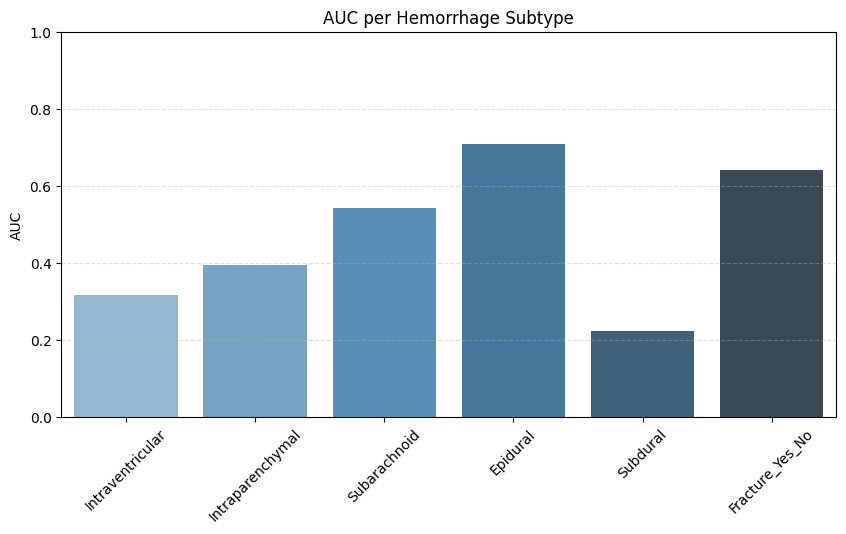

In [111]:
# AUC Bar Plot
import matplotlib.pyplot as plt
import seaborn as sns

subtypes = subtype_cols
auc_scores = [metrics[c]["AUC"] for c in subtypes]

plt.figure(figsize=(10, 5))
sns.barplot(x=subtypes, y=auc_scores, palette="Blues_d")
plt.title("AUC per Hemorrhage Subtype")
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

/tmp/ipykernel_47/1571745398.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subtypes, y=f1_scores, palette="Greens_d")


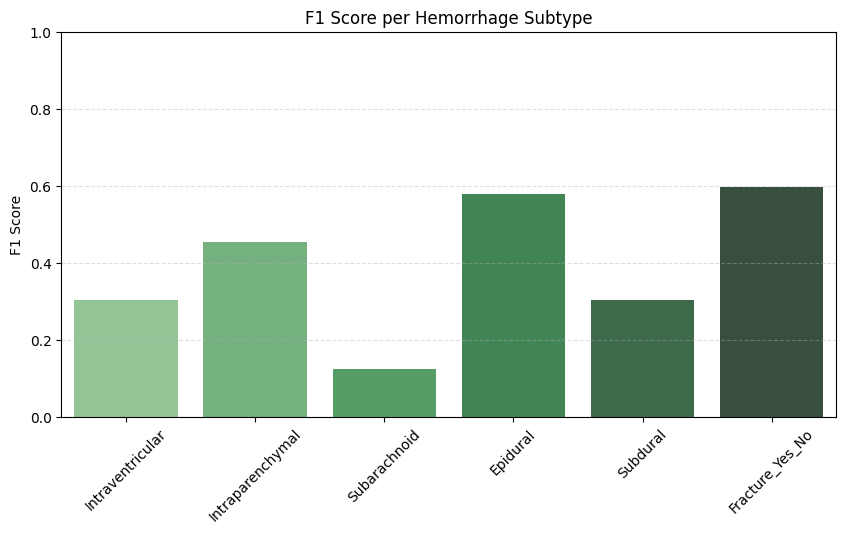

In [112]:
# F1 Score Bar Plot
f1_scores = [metrics[c]["F1"] for c in subtypes]

plt.figure(figsize=(10, 5))
sns.barplot(x=subtypes, y=f1_scores, palette="Greens_d")
plt.title("F1 Score per Hemorrhage Subtype")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=45)
plt.show()

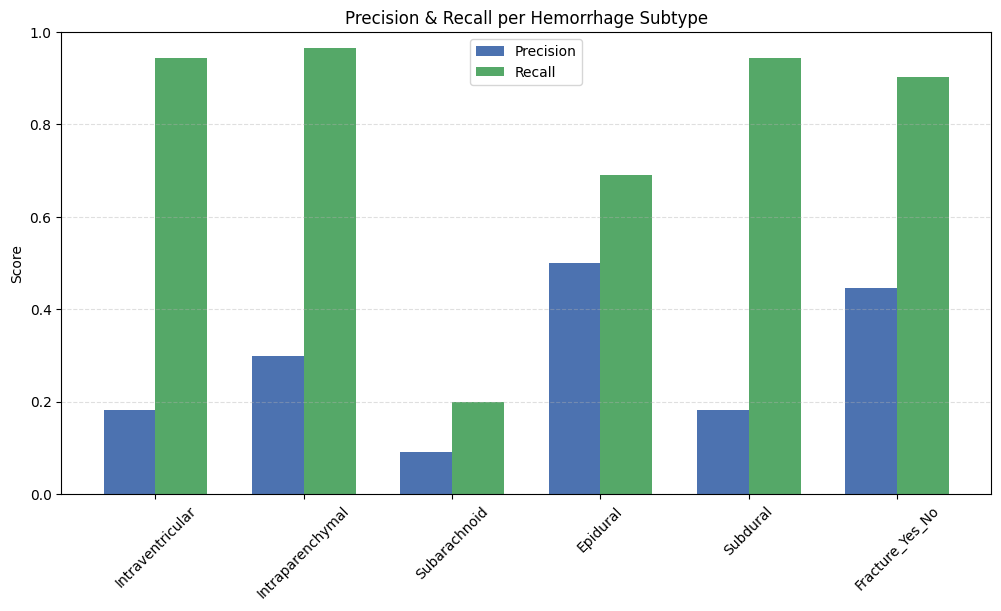

In [113]:
# Precision and Recall Side-by-Side
precisions = [metrics[c]["Precision"] for c in subtypes]
recalls = [metrics[c]["Recall"] for c in subtypes]

x = np.arange(len(subtypes))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, precisions, width, label="Precision", color="#4C72B0")
plt.bar(x + width/2, recalls,    width, label="Recall",    color="#55A868")

plt.xticks(x, subtypes, rotation=45)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Precision & Recall per Hemorrhage Subtype")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

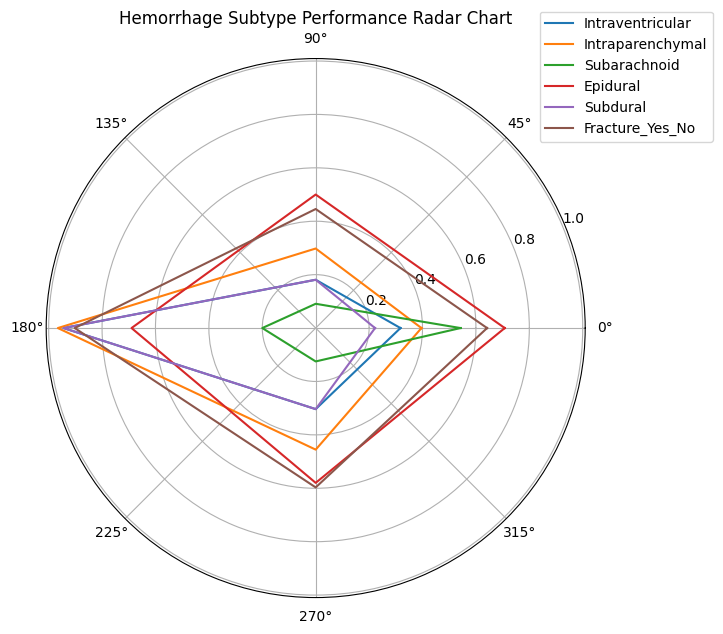

In [114]:
# Radar Chart
import numpy as np
import matplotlib.pyplot as plt

metrics_to_plot = ["AUC", "Precision", "Recall", "F1"]

angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7, 7))

for subtype in subtype_cols:
    values = [metrics[subtype][m] for m in metrics_to_plot]
    values += values[:1]
    plt.polar(angles, values, label=subtype)

plt.title("Hemorrhage Subtype Performance Radar Chart")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
plt.show()

## **Grad-CAM class for brain branch (multi-label aware)**

In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class SubtypeBrainGradCAM:
    def __init__(self, model, target_layer):
        """
        model: DualEfficientNetSubtype
        target_layer: layer from model.brain_net to hook (e.g. model.brain_net.features[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # forward hook
        self.fwd_hook = target_layer.register_forward_hook(self._save_activations)
        # backward hook
        self.bwd_hook = target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate_cam(self, brain_tensor, bone_tensor, class_idx):
        """
        brain_tensor, bone_tensor: [1, 3, H, W]
        class_idx: index in subtype_cols for which to generate Grad-CAM
        """
        self.model.eval()
        self.model.zero_grad()

        logits = self.model(brain_tensor, bone_tensor)    # [1, 6]
        score = logits[0, class_idx]                      # scalar for that subtype

        score.backward()

        # activations: [1, C, H, W]
        # gradients  : [1, C, H, W]
        grads = self.gradients
        acts  = self.activations

        # global average pool the gradients
        weights = grads.mean(dim=(2, 3))[0]        # [C]
        cam = (weights[:, None, None] * acts[0]).sum(dim=0)   # [H, W]

        cam = torch.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam.cpu().numpy()

In [116]:
brain_target_layer = best_model2.brain_net.features[-1]
subtype_gradcam = SubtypeBrainGradCAM(best_model2, brain_target_layer)

In [117]:
# visualize Grad-CAM for a chosen subtype
import torch
import torch.nn.functional as F

def visualize_subtype_gradcam(
    idx,
    subtype_name,
    df=test_df2,
    threshold_dict=None,
    show_all_probs=False
):
    """
    idx           : row index in df (test_df2 or val_df2)
    subtype_name  : one of subtype_cols, e.g. "Epidural"
    df            : DataFrame (test_df2 by default)
    threshold_dict: dict of best_thresholds per subtype; if None, use 0.5
    show_all_probs: if True, print all subtype probabilities
    """
    if threshold_dict is None:
        threshold_dict = {c: 0.5 for c in subtype_cols}

    if subtype_name not in subtype_cols:
        raise ValueError(f"{subtype_name} not in subtype_cols")

    subtype_idx = subtype_cols.index(subtype_name)

    row = df.iloc[idx]
    brain_path = row["brain_path"]
    bone_path  = row["bone_path"]

    true_labels = row[subtype_cols].values.astype(int)

    brain_img_orig = Image.open(brain_path).convert("RGB")
    bone_img_orig  = Image.open(bone_path).convert("RGB")

    # preprocess
    brain_tensor = val_tf(brain_img_orig).unsqueeze(0).to(device)
    bone_tensor  = val_tf(bone_img_orig).unsqueeze(0).to(device)

    best_model2.eval()
    with torch.no_grad():
        logits = best_model2(brain_tensor, bone_tensor)      # [1, 6]
        probs  = torch.sigmoid(logits)[0].cpu().numpy()      # [6]

    subtype_prob = float(probs[subtype_idx])
    thresh = float(threshold_dict.get(subtype_name, 0.5))
    pred_label = 1 if subtype_prob > thresh else 0
    true_label = int(true_labels[subtype_idx])

    print(f"Slice index: {idx}")
    print("Brain path :", brain_path)
    print("Bone path  :", bone_path)
    print(f"Subtype    : {subtype_name}")
    print(f"True label : {true_label}")
    print(f"Pred prob  : {subtype_prob:.4f}  | Threshold: {thresh:.3f}  | Pred: {pred_label}")

    if show_all_probs:
        print("\nAll subtype probabilities:")
        for c, p in zip(subtype_cols, probs):
            print(f"  {c:20s}: {p:.4f}")

    # CASE 1: subtype NOT predicted → only show image
    if pred_label == 0:
        plt.figure(figsize=(6,5))
        plt.imshow(brain_img_orig)
        plt.title(
            f"{subtype_name}: NOT predicted (prob={subtype_prob:.3f}, th={thresh:.3f})\n"
            f"True label: {true_label}"
        )
        plt.axis("off")
        plt.show()
        return

    # CASE 2: subtype predicted → Grad-CAM + bounding box
    brain_tensor.requires_grad = True
    bone_tensor.requires_grad  = True

    cam = subtype_gradcam.generate_cam(brain_tensor, bone_tensor, class_idx=subtype_idx)

    # resize CAM to original image size
    cam_resized = cv2.resize(cam, brain_img_orig.size)   # (W, H)

    # heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    brain_np = np.array(brain_img_orig)
    overlay = np.uint8(0.6 * brain_np + 0.4 * heatmap)

    # bounding box on high-activation area
    mask = cam_resized > 0.5  # you can tune 0.5
    mask_uint8 = np.uint8(mask * 255)

    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brain_with_box = brain_np.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(brain_with_box, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # plot
    plt.figure(figsize=(16,6))

    plt.subplot(1,3,1)
    plt.imshow(brain_img_orig)
    plt.title("Original Brain CT")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlay)
    plt.title(f"{subtype_name} Grad-CAM Overlay")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(brain_with_box)
    plt.title(f"Detected Region ({subtype_name})")
    plt.axis("off")

    plt.suptitle(
        f"{subtype_name} | prob={subtype_prob:.3f}, th={thresh:.3f}, "
        f"pred={pred_label}, true={true_label}",
        fontsize=13, y=1.02
    )

    plt.tight_layout()
    plt.show()

Slice index: 41
Brain path : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/071/brain/17.jpg
Bone path  : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/071/bone/17.jpg
Subtype    : Epidural
True label : 0
Pred prob  : 0.5401  | Threshold: 0.496  | Pred: 1

All subtype probabilities:
  Intraventricular    : 0.3660
  Intraparenchymal    : 0.2705
  Subarachnoid        : 0.3407
  Epidural            : 0.5401
  Subdural            : 0.4002
  Fracture_Yes_No     : 0.5091


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


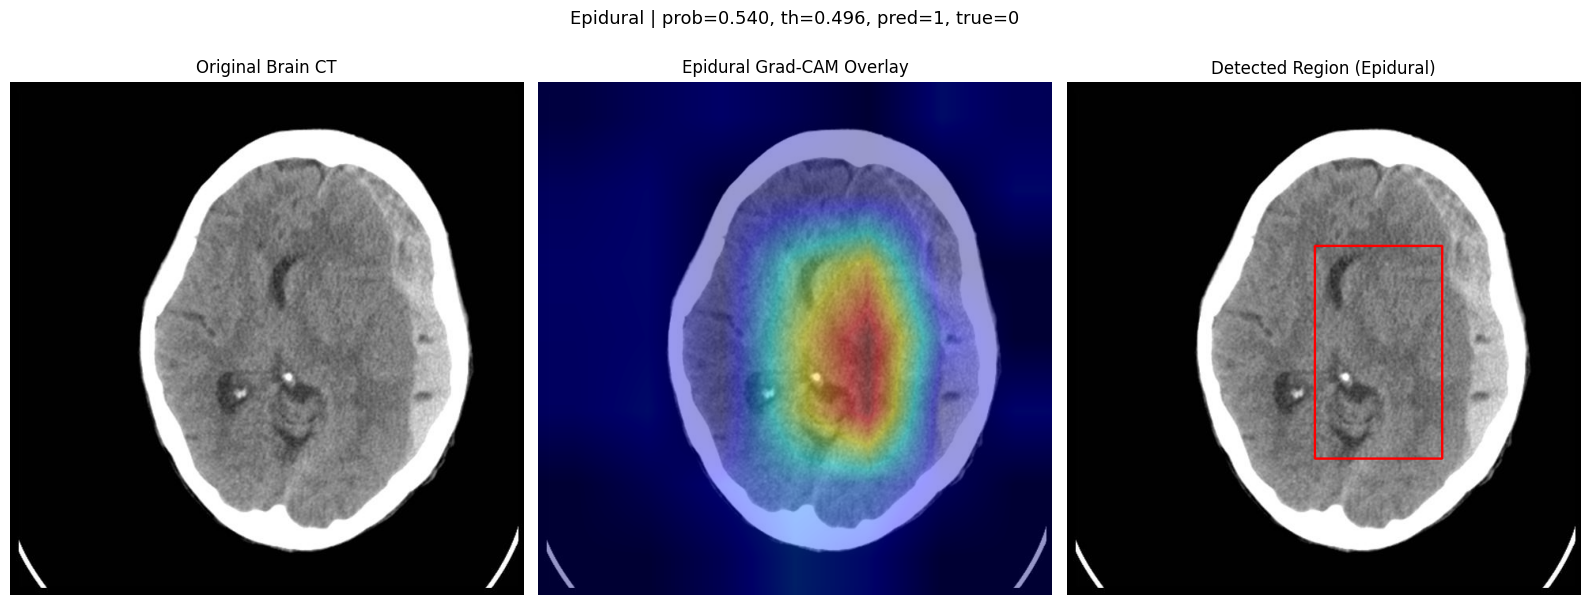

In [118]:
# Example: visualize Epidural on a random test slice
import random

idx = random.randint(0, len(test_df2)-1)
visualize_subtype_gradcam(
    idx=idx,
    subtype_name="Epidural",
    df=test_df2,
    threshold_dict=best_thresholds,   # from Step E
    show_all_probs=True
)

Slice index: 10
Brain path : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/brain/25.jpg
Bone path  : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/bone/25.jpg
Subtype    : Intraventricular
True label : 0
Pred prob  : 0.3705  | Threshold: 0.313  | Pred: 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


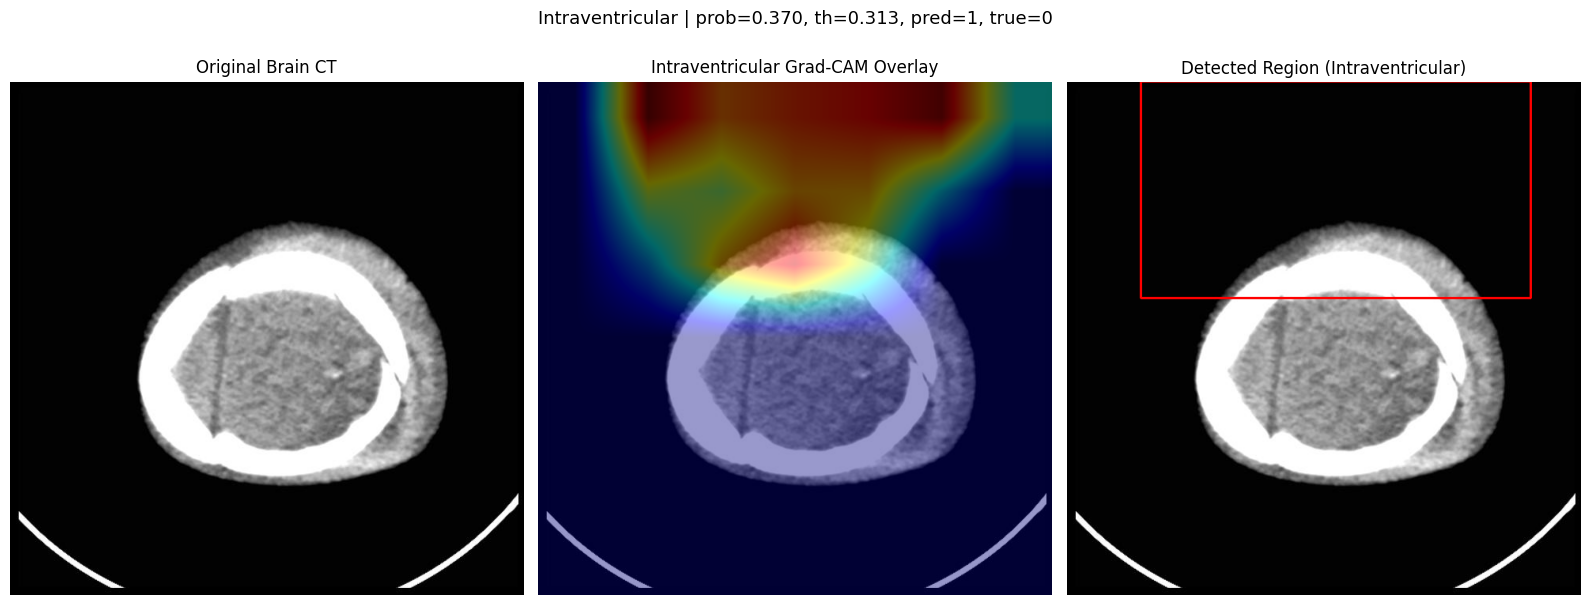

Slice index: 25
Brain path : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/070/brain/17.jpg
Bone path  : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/070/bone/17.jpg
Subtype    : Subarachnoid
True label : 0
Pred prob  : 0.4227  | Threshold: 0.434  | Pred: 0


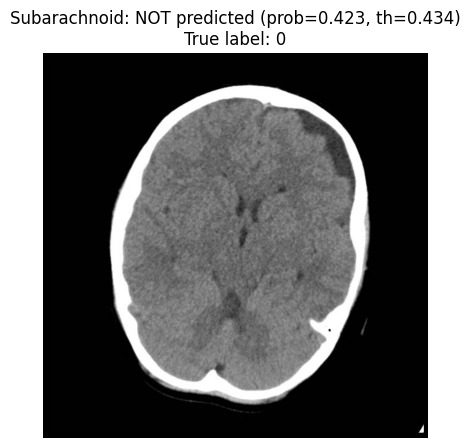

Slice index: 5
Brain path : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/brain/20.jpg
Bone path  : /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/050/bone/20.jpg
Subtype    : Fracture_Yes_No
True label : 1
Pred prob  : 0.5198  | Threshold: 0.446  | Pred: 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


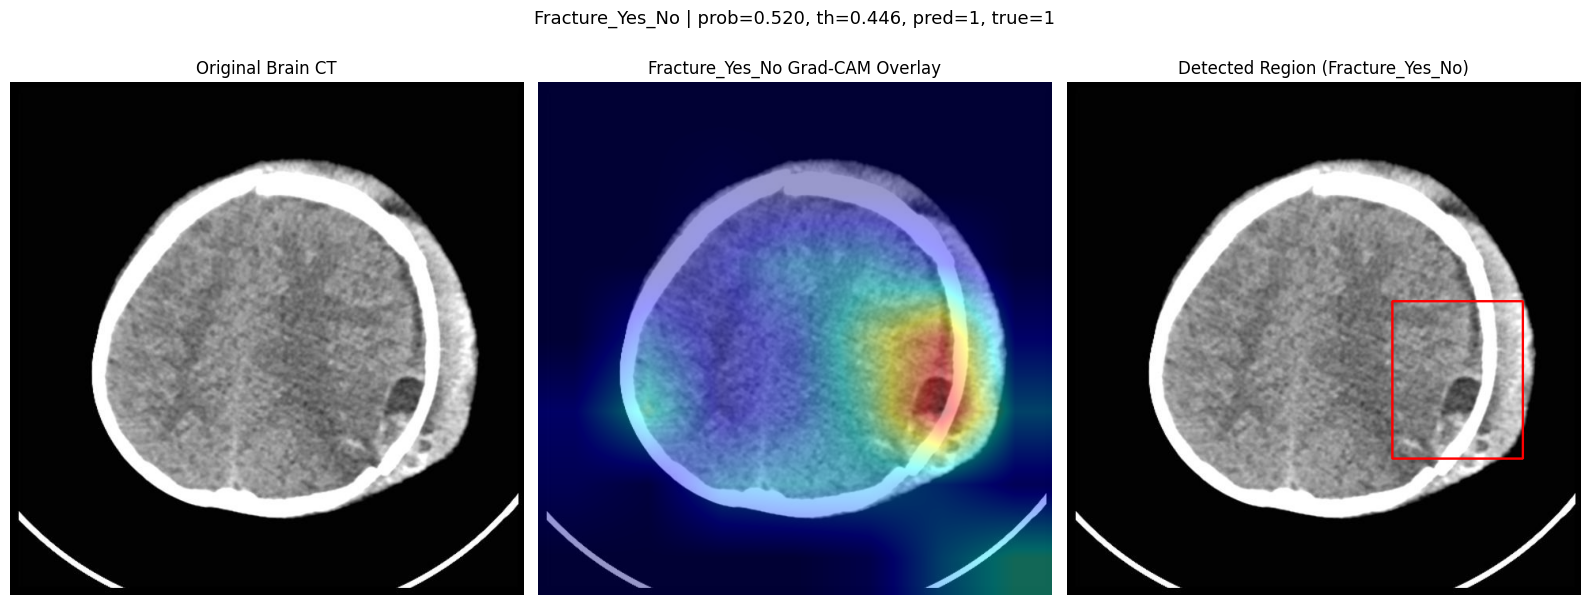

In [119]:
# For specific class
visualize_subtype_gradcam(10, "Intraventricular", df=test_df2, threshold_dict=best_thresholds)
visualize_subtype_gradcam(25, "Subarachnoid",    df=test_df2, threshold_dict=best_thresholds)
visualize_subtype_gradcam(5,  "Fracture_Yes_No", df=test_df2, threshold_dict=best_thresholds)